# Implementing  BVEP brain network model in Stan


In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import re
import glob
from itertools import chain
from operator import itemgetter

import json
import pickle

import scikitplot as skplt
from sklearn.metrics import confusion_matrix

from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
from parse_csv import parse_csv2
from read_csvs import read_samples

from report_nodetype import node_EzPzHz_idex
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage
from report_nodetype import node_score_std_extrm, node_score_ezpz

In [4]:
import warnings
import yaml

warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)
yaml.warnings({'YAMLLoadWarning': False})

In [5]:
%pylab inline
#%matplotlib inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


In [6]:
def f_int(x):
    return np.int(x)

f_vector_int = np.vectorize(f_int)

In [7]:
numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Syntetic Data

In [8]:
data_dir = 'data_input_files'
results_dir = 'data_output_files'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

In [9]:
cwd = os.getcwd()
print("The results directory is:", cwd)

The results directory is: /data/BVEP-master


In [10]:
#Res_dir='data_output_files''
Res_dir='data_output_hmc_BVEP_seeg_noncentered_MAP'

In [11]:
Mainpath =cwd+"/"

In [12]:
Reportmetrics_dir = os.path.join(cwd, Mainpath+"/data_output_files/figures/")

In [13]:
eta_true_inx, eta_true_mu, eta_true_sd = np.loadtxt(Mainpath+"ExperimentalData"+"/"+"eta_seeg_patient1"+".txt", delimiter=',', usecols=(0,1,2), skiprows=1, ).T 

In [14]:
with open(Mainpath+"ExperimentalData"+"/"+"true_labels_nodes_patient1"+".txt", 'r') as filehandle:  
          true_labels_nodes = json.load(filehandle)              

In [15]:
data_input = np.load(Mainpath+"data_input_files/"+"datainput_Seeg_84nodes_patient1.npz")
#data_input = np.load(f'{data_dir}/datainput_Seeg_84nodes_patient1.R.npz')

In [16]:
Obs_seeg = data_input['Obs_seeg']
x_source=data_input['x_source']
z_source=data_input['z_source']

SC = data_input['SC']
Gr = data_input['Gr']
ts = data_input['ts']
tau0 = data_input['tau0']
Ks = data_input['Ks']

ez_idx=data_input['ez_idx']
pz_idx=data_input['pz_idx']

ez_val=data_input['ez_val']
pz_val=data_input['pz_val']
hz_val=data_input['hz_val']

nn=data_input['nn']
ns=data_input['ns']
nt=data_input['nt']

In [17]:
nodes=np.r_[0:nn]

In [18]:
Obs_seeg.shape, x_source.shape

((130, 162), (130, 84))

In [19]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

In [20]:
eta_ez= float(ez_val)
eta_pz= float(pz_val)
eta_hz= float(hz_val)

In [21]:
eta_ez, eta_pz, eta_hz

(-1.6, -2.4, -3.5)

In [22]:
ez_idx, pz_idx

(array([ 6, 34], dtype=int32), array([27,  5, 11], dtype=int32))

In [23]:
Ez_indices, Pz_indices, Hz_indices, Ez_arr, Pz_arr, Hz_arr= node_EzPzHz_idex(true_labels_nodes)

In [24]:
print("Ez_indices:", Ez_indices)
print("Pz_indices:", Pz_indices)

Ez_indices: [6, 34]
Pz_indices: [5, 11, 27]


# Provisioning BVEP

## Observation

In [25]:
Obs_seeg.shape

(130, 162)

In [26]:
Seeg= Obs_seeg.T
Seeg.shape

(162, 130)

In [27]:
Seeg_area = np.trapz(Seeg, dx=0.0001)

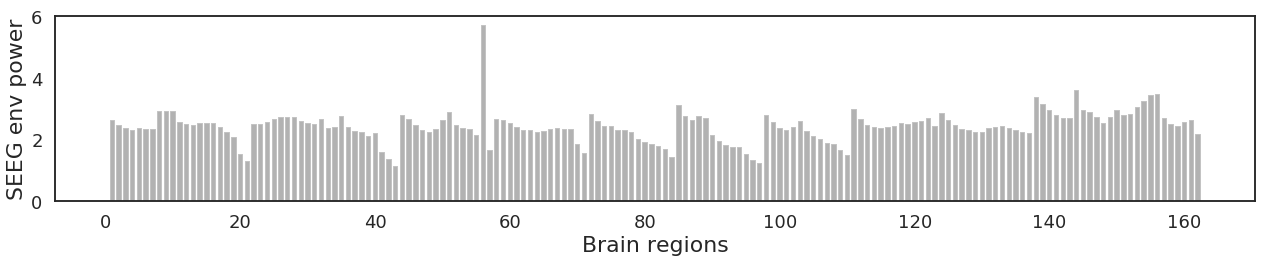

In [28]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,Seeg_area.shape[0]+1), -Seeg_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('SEEG env power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power.eps"), doi=800)
plt.show()

In [29]:
Seeg_pwr = np.sum((Seeg*Seeg), axis=1)
Seeg_pwr_n = (Seeg_pwr/ Seeg_pwr.max())

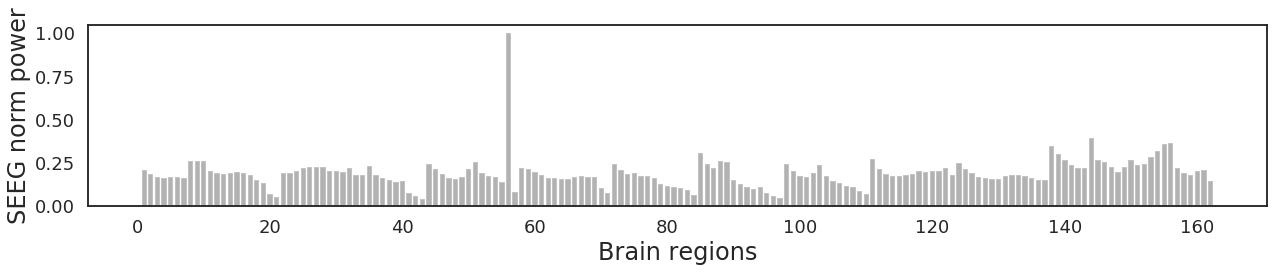

In [30]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1, Seeg_pwr_n.shape[0]+1), Seeg_pwr_n, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=24)
plt.ylabel('SEEG norm power', fontsize=24)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power_normalize.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power_normalize.eps"), doi=800)
plt.show()

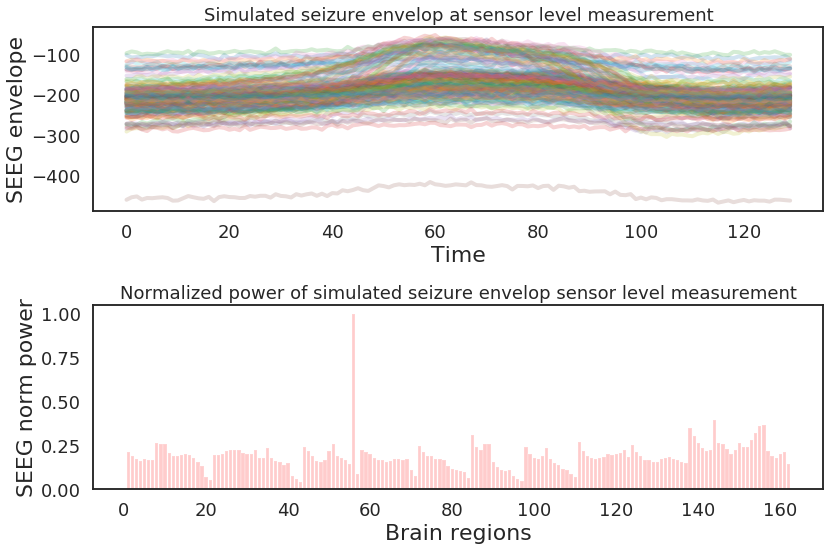

In [31]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(Seeg.T, linewidth=4, alpha=0.2);
plt.title('Simulated seizure envelop at sensor level measurement')
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG envelope', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(212)
plt.bar(np.arange(1,Seeg_pwr_n.shape[0]+1), Seeg_pwr_n, color='r', alpha=0.2)
plt.title('Normalized power of simulated seizure envelop sensor level measurement')
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('SEEG norm power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Observed_SEEGdata.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Observed_SEEGdata.eps"), doi=800)
plt.show()

In [32]:
xs=x_source
zs=z_source

xs.shape, zs.shape

((130, 84), (130, 84))

In [33]:
xs_pwr = (xs*xs).sum (axis=0)
xs_pwr_n = (xs_pwr/ xs_pwr.max())

In [34]:
eni_idx=np.argsort(xs_pwr)
eni_idx

array([ 6, 34, 27, 11,  5, 83,  9, 29,  7, 23, 60, 14, 13, 20,  3, 28, 54,
       22, 39, 35,  8, 19,  4, 26,  0,  2, 58, 72, 76, 37, 33, 52, 63, 10,
       57, 36, 25, 68, 56, 15, 42, 38, 31, 12, 53, 40, 69, 32, 46, 75, 64,
       77, 21, 71, 43, 59, 44, 78, 16, 82, 62, 45, 61, 70, 18, 17, 41,  1,
       24, 55, 47, 74, 48, 80, 51, 30, 81, 66, 73, 79, 67, 50, 65, 49])

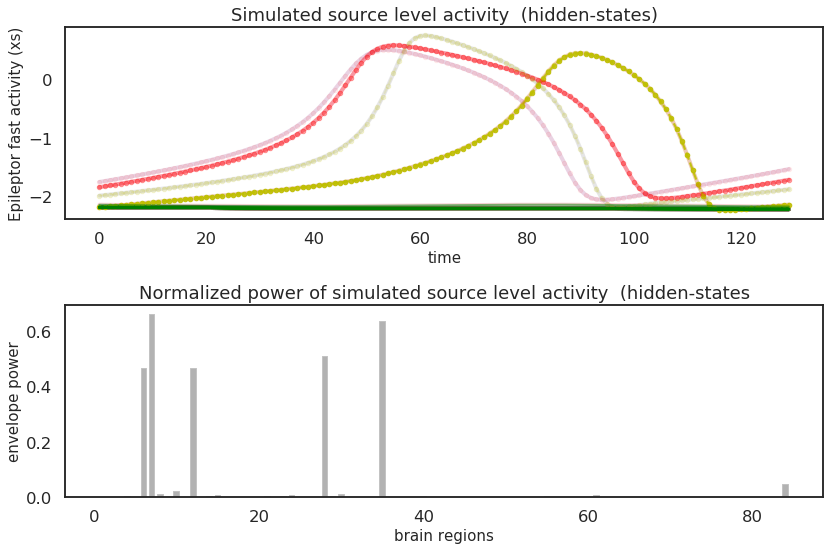

In [35]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(xs, linewidth=4, alpha=0.2);
for i in range(xs.shape[1]):
    if i in Ez_indices:
        plot(xs[:,i], linestyle='-', marker='.', linewidth=4, color='r', alpha=2./i)
    elif i in Pz_indices:
        plot(xs[:,i], linestyle='--', marker='.',linewidth=2, color='y', alpha=4./i)
    else: 
        plot(xs[:,i], linestyle='-', linewidth=2, color='g', alpha=0.5)
plt.title('Simulated source level activity  (hidden-states)')
plt.xlabel('time', fontsize=15)
plt.ylabel('Epileptor fast activity (xs)', fontsize=15)
plt.subplot(212)
plt.bar(np.arange(1,xs_pwr_n.shape[0]+1), 1.-xs_pwr_n, color='black', alpha=0.3)
plt.title('Normalized power of simulated source level activity  (hidden-states')
plt.xlabel('brain regions', fontsize=15)
plt.ylabel('envelope power', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"UnobserveSourceActivity.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"UnobserveSourceActivity.eps"), doi=800)
plt.show()

In [36]:
Seeg.shape, xs.shape

((162, 130), (130, 84))

## NonCenterized form of parameterization

In [37]:
! cat BVEP_seeg_noncentered_reparam.stan

data {
  int nn;  //number of brain regions
  int nt;  //number of data points per sensor
  int ns;  //number of sensors

  real dt;    //time step in Euler integration
  real tau0;  //time scale in Eipleptor model
  real I1;    //input current in in Eipleptor model
  real Ks;    //global connectivity parameter

  matrix[nt, ns] Obs_seeg;      // observation at sensor-level
  matrix[nn, nn] SC;           // brain structural connectivity
  matrix[ns, nn] Gr;           // gain (projection matrix)
  matrix[nn, nn] eigen_vec;   // eigen vectors of dot(Gr.T, Gr)
 
  real zlim[2]; 
  real xlim[2]; 

}

transformed data {
  vector[nt*ns] Obs_seeg_vect;
  Obs_seeg_vect=to_vector(Obs_seeg);
}

parameters {
  vector[nn] x_init_star;
  vector[nn] z_init_star;
  vector[nn] eta_star;
  real <lower=-1.0> K_star;
  real <lower=-1.0> amplitude_star;
  vector [ns] offset_star;
  real eps_star;
}

transformed parameters {
  vector[nn] eta;
  vector[nn] x_init;
  vector[nn] z_init;
  real K;
  real ampli

In [38]:
model=str('BVEP_seeg_noncentered_reparam')

In [39]:
curr_dir=cwd

In [40]:
! cd /home/meysam/cmdstan && make $curr_dir/$model && cd $curr_dir

make: '/data/BVEP-master/BVEP_seeg_noncentered_reparam' is up to date.


In [41]:
%%bash

iter_opt=100000

alg=opt
model=BVEP_seeg_noncentered_reparam
data_input=datainput_Seeg_84nodes_patient1.R
data_output=data_output_${alg}_${model}

mkdir -p ${data_output}

log_file=report_convergence_${model}_${data_input}.txt

echo "Opt started for" ${alg}_${model} >> ${log_file}

for i in `seq 1`
do
       ./$model id=$i\
        optimize \
        iter=$iter_opt \
        data file=data_input_files/${data_input}\
        output file=${data_output}/output_${alg}_${model}_$i.R refresh=1 \
        &> ${data_output}/output_${alg}_${model}_$i.out &
                                                                      
done
#wait

echo "Opt Finished for" ${alg}_${model} >> ${log_file}

In [42]:
fit_foldername="data_output_opt_"+model
fit_filename="output_opt_"+model

In [43]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/BVEP-master/data_output_opt_BVEP_seeg_noncentered_reparam'

In [44]:
! ls $dir_data_output

output_opt_BVEP_seeg_noncentered_reparam_1.out
output_opt_BVEP_seeg_noncentered_reparam_1.R


In [45]:
!tail -n2 $dir_data_output/*$model*out

Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


## check the convergence 

In [46]:
chain=1

In [47]:
cvsfinemane='output_opt_'+str(model)+'_'+str(chain)+'.csv'
cvsfinemane

'output_opt_BVEP_seeg_noncentered_reparam_1.csv'

In [48]:
fit_filename_csv= fit_filename +'_'+ str(chain)+'.R'
fit_filename_out= fit_filename +'_'+ str(chain)+'.out'

In [49]:
with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
    lines = f.readlines()
    last_lines = lines[-7:]
    print (last_lines[1], last_lines[3], last_lines[4], last_lines[5]  )

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     3728      -50277.1    0.00129472       36.0726           1           1     5607   
 Optimization terminated normally: 



In [50]:
nSample=1

## posterior predictive density 

In [51]:
fit= parse_csv2(dir_data_output+"/", fit_filename_csv)

In [52]:
for key, val in fit.items():
    print(key, val.shape)

lp__ (1,)
x_init_star (1, 84)
z_init_star (1, 84)
eta_star (1, 84)
K_star (1,)
amplitude_star (1,)
offset_star (1, 162)
eps_star (1,)
eta (1, 84)
x_init (1, 84)
z_init (1, 84)
K (1,)
amplitude (1,)
offset (1, 162)
eps (1,)
x (1, 130, 84)
z (1, 130, 84)
Seeg_qqc (1, 162, 130)
Seeg_qqc_vect (1, 21060)
Seeg_ppc (1, 21060)
log_lik (1, 21060)
log_lik_sum (1, 130)
gx (1,)
dx (1,)
dz (1,)


In [53]:
lp=fit['lp__']
lp

array([-50277.1])

In [54]:
Seeg_est=fit['Seeg_qqc'][-nSample:]
x_est=fit['x'][-nSample:]
z_est=fit['z'][-nSample:]

In [55]:
Seeg_est.shape, x_est.shape

((1, 162, 130), (1, 130, 84))

In [56]:
Seeg.shape, xs.shape

((162, 130), (130, 84))

In [57]:
eta_est=fit['eta'][-nSample:]
K_est=fit['K'][-nSample:]
amplitude_est=fit['amplitude'][-nSample:]
offset_est=fit['offset'][-nSample:]
eps_est=fit['eps'][-nSample:]

In [58]:
eta_est.shape, K_est.shape, amplitude_est.shape, offset_est.shape, eps_est.shape

((1, 84), (1,), (1,), (1, 162), (1,))

In [59]:
eta_est_mean=np.mean(eta_est, axis=0)
eta_est_std=np.std(eta_est, axis=0)

In [60]:
Seeg_est_low, Seeg_est_hi = percentile(Seeg_est, [5, 95], axis=0)
LSE_val_fit=LSE_obs(Seeg, Seeg_est_low, Seeg_est_hi)
print('LSE_val_fit=', LSE_val_fit)

LSE_val_fit= 196736.8030467559


In [61]:
x_est_low, x_est_hi = percentile(x_est, [5, 95], axis=0)
LSE_val_fit_x=LSE_obs(xs, x_est_low, x_est_hi)
print('LSE_val_nuts=', LSE_val_fit_x)

LSE_val_nuts= 4.67437702953986


In [62]:
err_eta_est=Err(eta_true_mu, eta_est_mean)
z_score_eta_est=np.sum(z_score(eta_true_mu, eta_est_mean, eta_est_std))
shrinkage_eta_est=np.mean(shrinkage([prior_std]*nodes.shape[0], eta_est_std))

In [63]:
score_std_est, score_extrm_est= node_score_std_extrm(nodes, eta_est, eta_true_mu, sd_thr)
score_ez_est, score_pz_est, ce_est, cp_est, nodes_est_est, est_labels_nodes= node_score_ezpz(nodes, eta_est, true_labels_nodes, eta_c, delta_eta, 1.)
print ('Prediction about Ez and Pz nodes is=', int(score_ez_est+score_pz_est),' out of', len(Ez_indices)+len(Pz_indices), ' EzPznodes')                                              

Prediction about Ez and Pz nodes is= 5  out of 5  EzPznodes


In [64]:
y_true=true_labels_nodes
y_pred=est_labels_nodes                                           
confusion_matrix_values= confusion_matrix(y_true, y_pred, labels=["EZ", "PZ", "HZ"])
accuracy_nuts=100*np.trace(confusion_matrix_values)/np.sum(confusion_matrix_values)
print ('Prediction about all the node types is=', int(np.trace(confusion_matrix_values)),' out of', len(nodes), ' nodes')

Prediction about all the node types is= 84  out of 84  nodes


In [65]:
showpicks = f_vector_int(np.r_[int(Hz_indices[0]), int(Pz_indices[0]), int(Ez_indices[0])])
showpicks=showpicks.tolist()
print("Shown nodes are:", [(x+1) for x in showpicks])

Shown nodes are: [1, 6, 7]


In [66]:
Seeg.shape, Seeg_est.shape, Seeg_est_low.shape

((162, 130), (1, 162, 130), (162, 130))

In [67]:
xs.shape, x_est.shape, x_est_low.shape

((130, 84), (1, 130, 84), (130, 84))

In [68]:
from report_plots import plot_features, plot_zscore_shrinkage,  plot_posterior, ppplot, plot_obs_x, plot_obs_z, plot_hiddenstates_x, plot_hiddenstates_z, plot_confusion_matrix

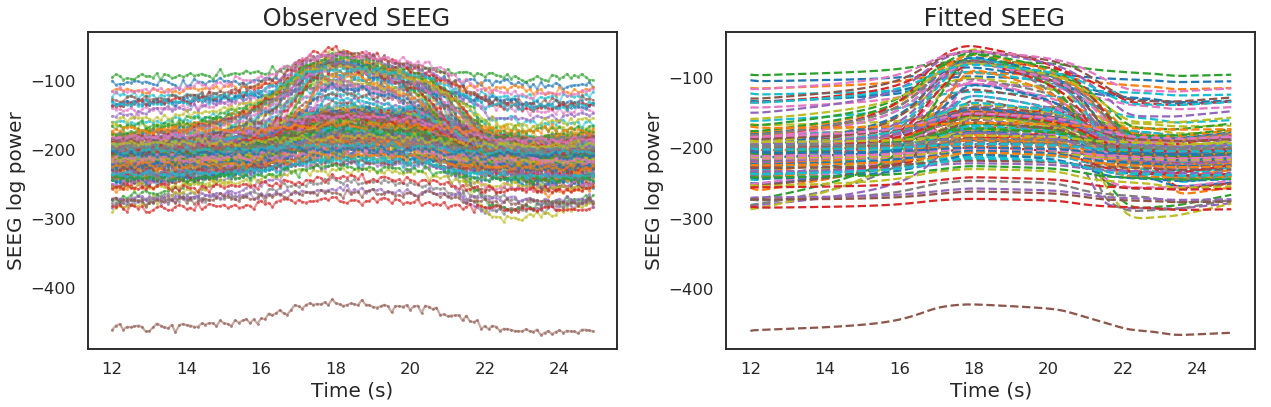

In [69]:
plt.figure(figsize=(18, 6)) 
subplot(121)
plt.plot(ts, Seeg.T, alpha=0.5, marker= '.' , markersize=4)
plt.title(' Observed SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
subplot(122)
plt.plot(ts, np.mean(Seeg_est, axis=0).T,  '--' , markersize=2)
plt.title(' Fitted SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_chain_"+str(chain)+".eps"), doi=800)
plt.show()

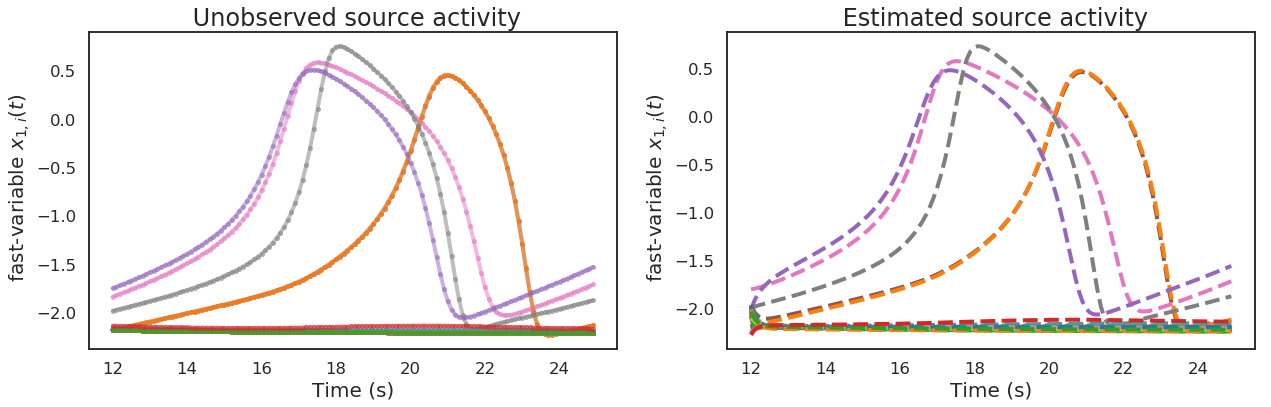

In [70]:
plt.figure(figsize=(18, 6)) 
subplot(121)
plt.plot(ts, xs, alpha=0.5, marker= '.' , markersize=8, lw=4)
plt.title(' Unobserved source activity', fontsize=24);
plt.ylabel(' fast-variable ' + r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
subplot(122)
plt.plot(ts, np.mean(x_est, axis=0),  '--' , markersize=8, lw=4)
plt.title(' Estimated source activity', fontsize=24);  
plt.ylabel(' fast-variable ' +r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_chain_"+str(chain)+".eps"), doi=800)
plt.show()

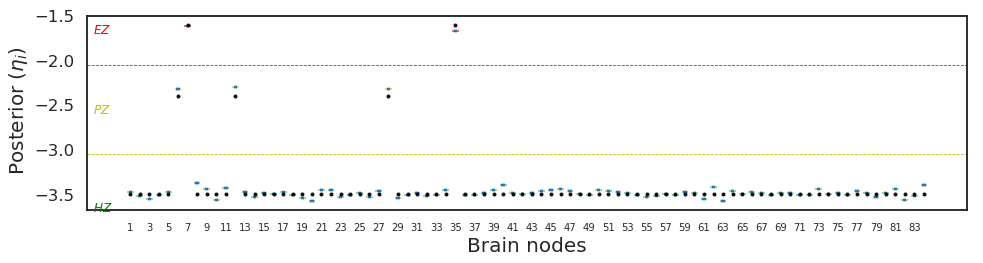

In [71]:
plt.figure(figsize=(14, 4)) 
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), eta_est)
plt.xticks(np.arange(1,len(nodes)+2, step=2),np.arange(1, len(nodes)+1, step=2), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=20);  
plt.xlabel('Brain nodes', fontsize=20); 
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_chain_"+str(chain)+".eps"), doi=800)
plt.show()

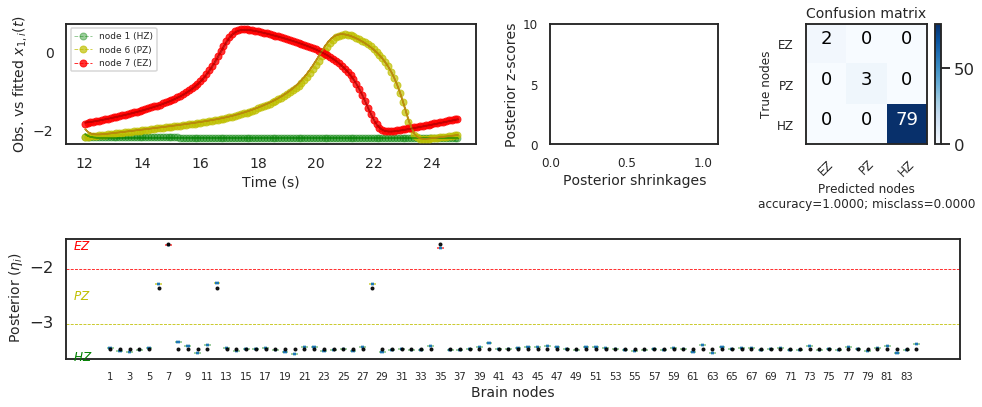

In [72]:
plt.figure(figsize=(14, 6))  
grid = plt.GridSpec(2, 4)  
plt.subplot(grid[0, :2]) 
plot_features(ts, xs, x_est, showpicks)
plt.subplot(grid[0, 2]) 
plot_zscore_shrinkage(nodes, eta_true_mu, eta_est_mean, eta_est_std, prior_std)
plt.subplot(grid[0, 3]) 
plot_confusion_matrix(confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.subplot(grid[1, 0:])            
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), eta_est)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FitSource"+str(model)+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FitSource"+str(model)+"_chain_"+str(chain)+".eps"), doi=800)
plt.show()

In [73]:
from report_plots import func_2DepileptorEqs,  plot_phasespace

I=I1+1;
InitialGuess=np.array([[-1.0, 3.0]])
rGuess = np.repeat(InitialGuess, int(nn), axis=0)

true_roots_K0 = fsolve(func_2DepileptorEqs,rGuess, args=(eta_true_mu, 0.0, I, SC))
true_roots = fsolve(func_2DepileptorEqs,rGuess, args=(eta_true_mu, Ks, I, SC))

estimated_roots_K0 = fsolve(func_2DepileptorEqs,rGuess, args=(eta_est_mean, 0.0, I, SC))
estimated_roots = fsolve(func_2DepileptorEqs,rGuess, args=(eta_est_mean, K_est.mean(), I, SC))

In [74]:
#in plot_phasespace from report_plots.py set:
#Nsamples=1
#j=0

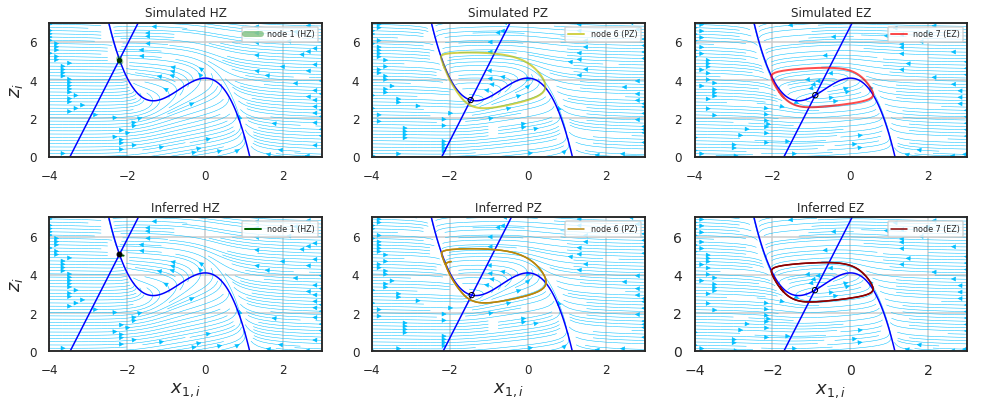

In [75]:
plt.figure(figsize=(14, 6)) 
plot_phasespace(fit, data_input, nodes, showpicks, SC,  eta_true_mu, Ks,  true_roots, true_roots_K0, estimated_roots, estimated_roots_K0);
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Phaseplane"+str(model)+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Phaseplane"+str(model)+"_chain_"+str(chain)+".eps"), doi=800)
plt.show();